### Mix model: approach 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from collections import Counter

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import resample



def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:    
        print('Confusion matrix, without normalization')
         
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0])
                                  , range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

,age,sex,text,isced,isced2,#anwps,clean_text,count_char,count_punct,count_word,avg_wordlength,count_misspelled,word_uniqueness
0,22,m,about me:i would love to think that i was some...,3.0,Upper secondary education,15.000000,mei love think kind intellectualeither dumbest...,1588,59,350,4.54,30,0.63
1,38,m,"i'm not ashamed of much, but writing public te...",7.0,Master or equivalent,18.000000,im ashamed writing public text onlinedating si...,2437,103,455,5.36,51,0.69
2,23,m,i work in a library and go to school. . . read...,3.0,Upper secondary education,10.750000,work library school reading things written old...,195,4,43,4.53,1,0.90
3,29,m,hey how's it going? currently vague on the pro...,6.0,Bachelor or equivalent,11.833333,hey hows going currently vague profile know to...,284,23,59,4.81,8,0.84
4,29,m,"i'm an australian living in san francisco, but...",6.0,Bachelor or equivalent,11.840000,im australian living san francisco dont hold t...,1155,58,245,4.71,23,0.68


In [53]:
# Read metadata dataset to dataframe

df = pd.read_csv (r'../../../data/processed/stylo_cupid2.csv')

df['sex'].mask(df['sex'].isin(['m']) , 0.0, inplace=True)
df['sex'].mask(df['sex'].isin(['f']) , 1.0, inplace=True)
# print(df['sex'].value_counts())

df['isced'].mask(df['isced'].isin([3.0, 5.0]) , 1.0, inplace=True)
df['isced'].mask(df['isced'].isin([6.0, 7.0]) , 8.0, inplace=True)

# # Separate majority and minority classes
# df_majority = df[df.isced==8.0]
# df_minority = df[df.isced==1.0]
 
# # Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,    # sample without replacement
#                                  n_samples=10985,     # to match minority class
#                                  random_state=123) # reproducible results
 
# # Combine minority class with downsampled majority class
# df = pd.concat([df_majority_downsampled, df_minority])



print(sorted(Counter(df['isced']).items()))
df = df.dropna(subset=['clean_text', 'isced'])

corpus = df[['clean_text', 'count_char','count_word', '#anwps', 'count_punct', 'avg_wordlength', 'count_misspelled', 'word_uniqueness', 'age', 'sex']]
target = df["isced"]

# vectorization
X_train, X_val, y_train, y_val = train_test_split(corpus, target, train_size=0.75,
                                                          test_size=0.25, random_state = 0)


get_text_data = FunctionTransformer(lambda x: x['clean_text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[['count_char','count_word', '#anwps', 'count_punct', 'avg_wordlength', 'count_misspelled', 'word_uniqueness', 'age', 'sex']], validate=False)



[(1.0, 10985), (8.0, 38958)]


Final Accuracy for Logistic: 0.8360708276580402
Confusion matrix, without normalization
[[1560 1155]
 [ 891 8875]]
              precision    recall  f1-score   support

         1.0       0.64      0.57      0.60      2715
         8.0       0.88      0.91      0.90      9766

    accuracy                           0.84     12481
   macro avg       0.76      0.74      0.75     12481
weighted avg       0.83      0.84      0.83     12481



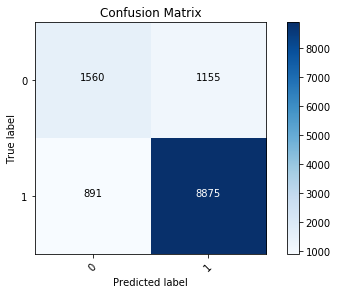

In [55]:
process_and_join_features = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('scaler', preprocessing.StandardScaler())
                
            ])),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', CountVectorizer(binary=False, ngram_range=(1, 2), lowercase=True))
            ]))
         ])),
    ('clf', LogisticRegression(random_state=0,max_iter=1000, solver='lbfgs', penalty='l2', class_weight='balanced'))
])

# 
# process_and_join_features.fit(X_train, y_train)
# predictions = process_and_join_features.predict(X_val)


# print("Final Accuracy for Logistic: %s"% accuracy_score(y_val, predictions))
# cm = confusion_matrix(y_val,predictions)
# plt.figure()
# plot_confusion_matrix(cm, classes=[0,1], normalize=False,
#                       title='Confusion Matrix')
# print(classification_report(y_val, predictions))

In [65]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


# scores = cross_val_score(process_and_join_features, X_train, y_train, cv=5)
# print(scores)
# print(scores.mean())

process_and_join_features.fit(X_train, y_train)

y_pred = cross_val_predict(process_and_join_features, corpus, target, cv=5)


In [66]:
conf_mat = confusion_matrix(target, y_pred)
print(conf_mat)

[[ 6257  4723]
 [ 3387 35557]]


In [70]:
from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(process_and_join_features, corpus, target, cv=5)
print(scores)
print(scores.mean())

[0.83755633 0.84076114 0.84036054 0.82934402 0.83974359]
0.8375531245586328
